# Background on the Types of Time Series Data
![img](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

In [1]:
!pip install prophet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')



# Data
The data we will be using is hourly power consumption data from PJM. Energy consumption has some unique characteristics. It will be interesting to see how prophet picks them up.
 
Pulling the `PJM East` which has data from 2002-2018 for the entire east region.
 

In [3]:
pjme = pd.read_csv('PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


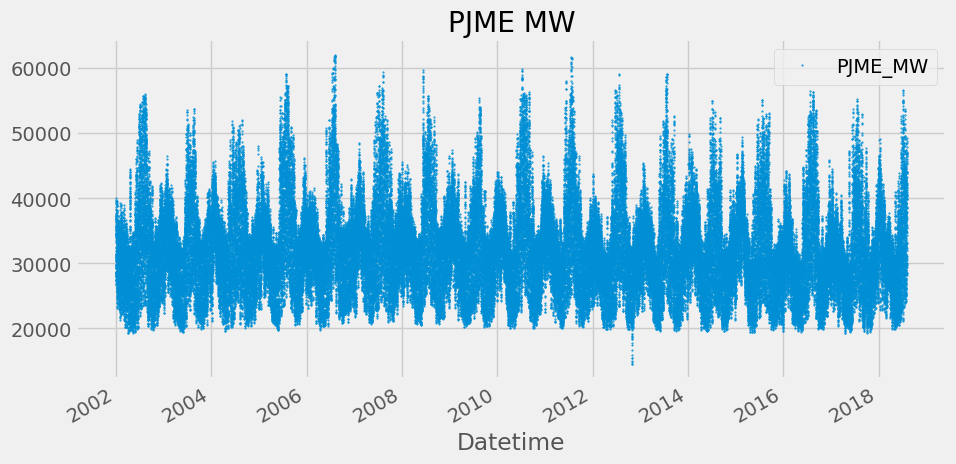

In [4]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

# Time Series Features

In [5]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

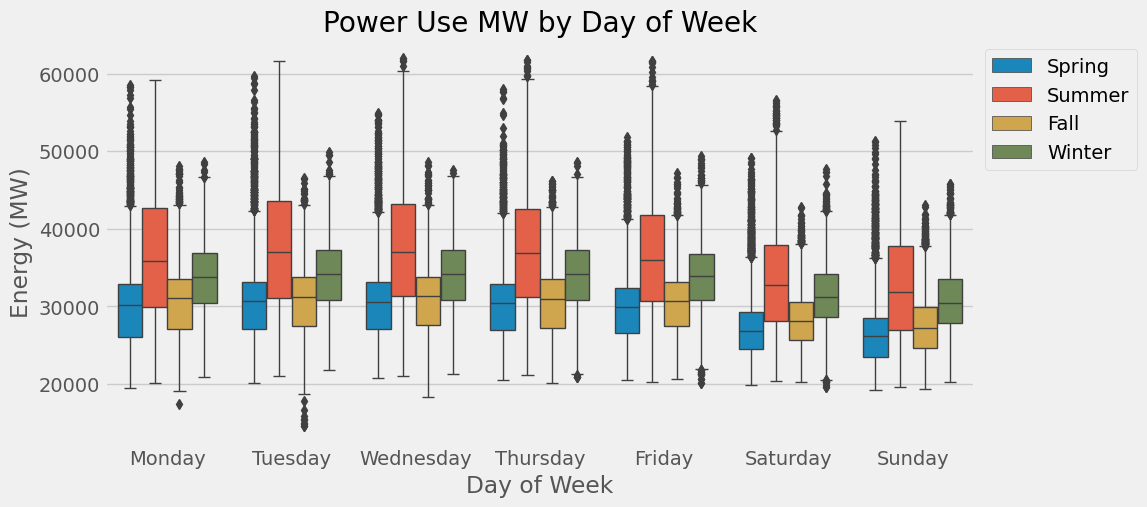

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

# Train / Test Split

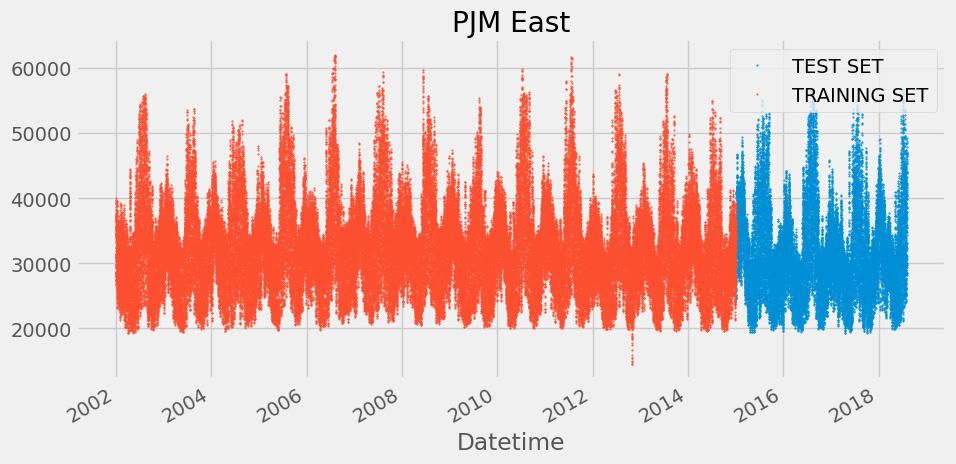

In [7]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

# Simple Prophet Model
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
    - Datetime column named: `ds`
    - target : `y`

In [8]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [9]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

22:01:53 - cmdstanpy - INFO - Chain [1] start processing
22:03:19 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 11.9 s
Wall time: 1min 41s


In [10]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [11]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31200.339206,23903.861641,33102.945918,31200.339206,31200.339206,-2842.562168,-2842.562168,-2842.562168,-4430.590454,...,1281.474328,1281.474328,1281.474328,306.553958,306.553958,306.553958,0.0,0.0,0.0,28357.777038
1,2015-01-01 02:00:00,31200.300721,22265.333502,31353.833084,31200.300721,31200.300721,-4347.079710,-4347.079710,-4347.079710,-5927.617356,...,1272.694228,1272.694228,1272.694228,307.843418,307.843418,307.843418,0.0,0.0,0.0,26853.221011
2,2015-01-01 03:00:00,31200.262235,21388.763516,30347.139536,31200.262235,31200.262235,-5218.803832,-5218.803832,-5218.803832,-6790.687108,...,1262.708907,1262.708907,1262.708907,309.174370,309.174370,309.174370,0.0,0.0,0.0,25981.458403
3,2015-01-01 04:00:00,31200.223749,21455.607645,30205.618119,31200.223749,31200.223749,-5360.281813,-5360.281813,-5360.281813,-6922.470785,...,1251.642133,1251.642133,1251.642133,310.546839,310.546839,310.546839,0.0,0.0,0.0,25839.941936
4,2015-01-01 05:00:00,31200.185263,21975.942415,31207.866292,31200.185263,31200.185263,-4685.843322,-4685.843322,-4685.843322,-6237.434051,...,1239.629878,1239.629878,1239.629878,311.960851,311.960851,311.960851,0.0,0.0,0.0,26514.341942


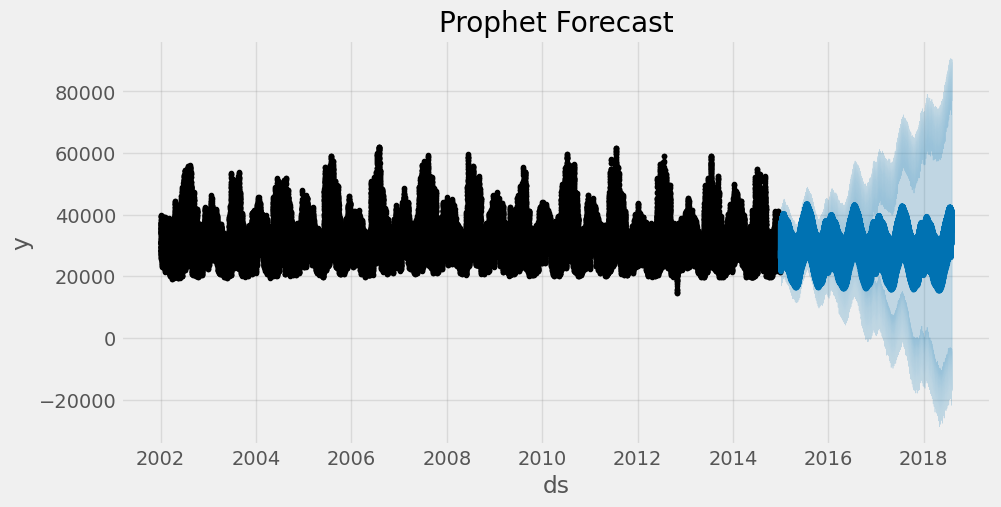

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

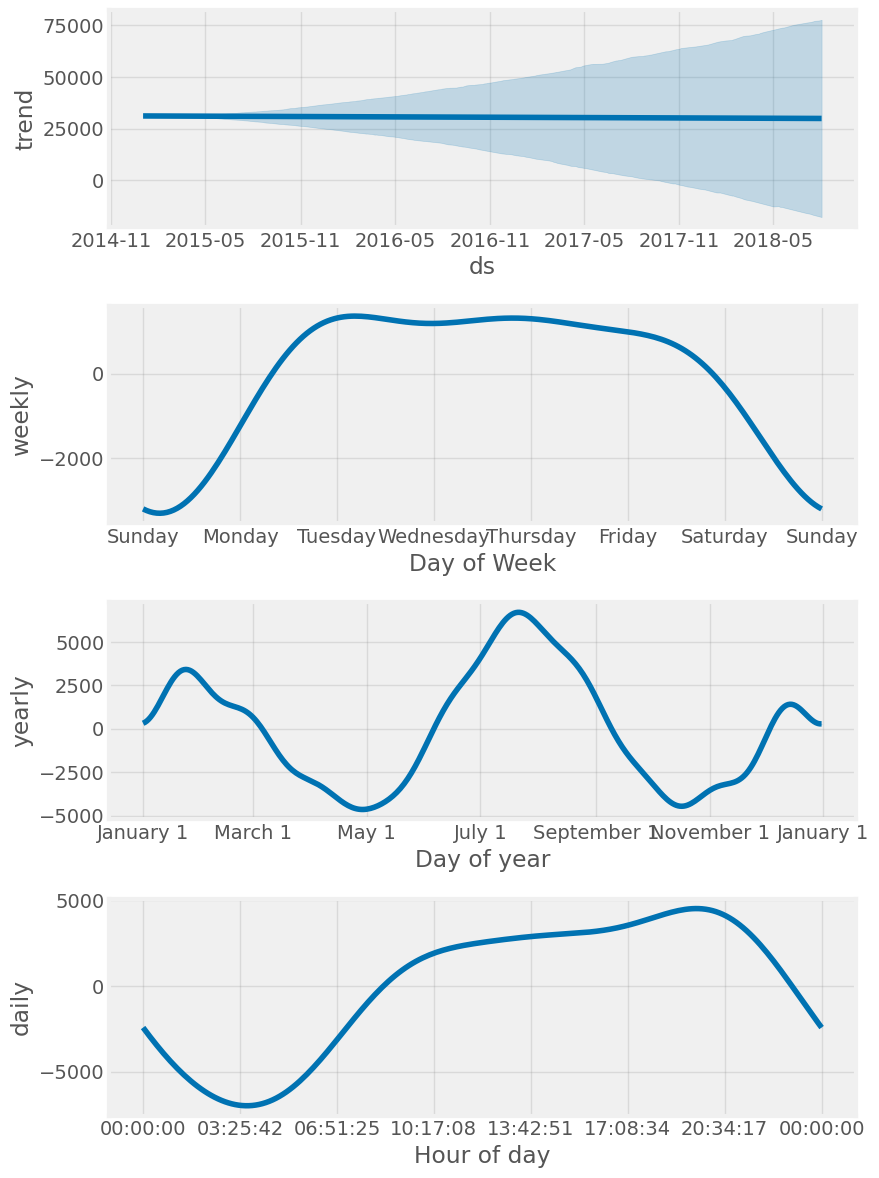

In [13]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

# Compare Forecast to Actuals

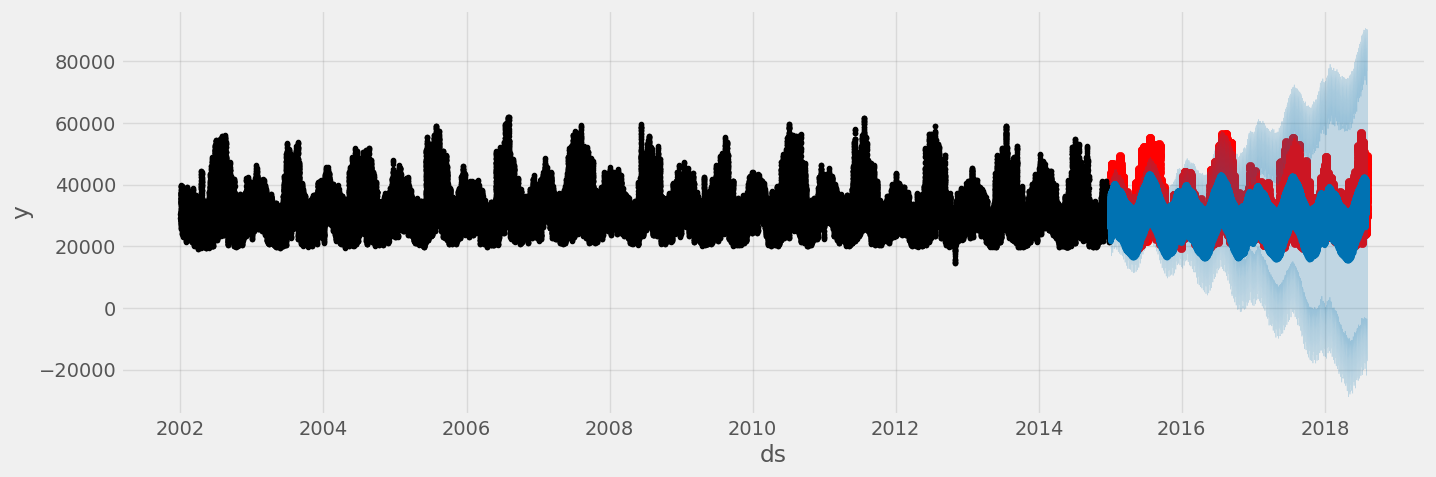

In [14]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

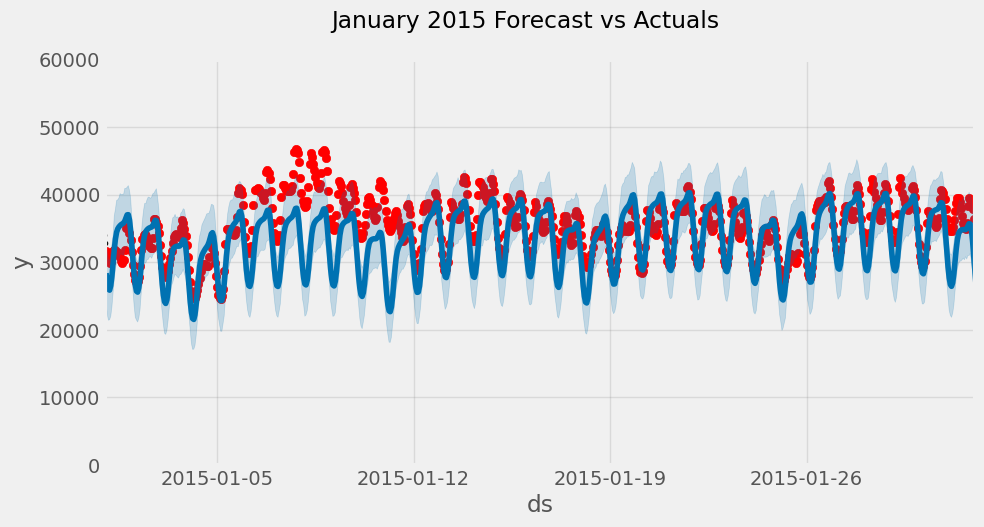

In [15]:

lower_date = pd.to_datetime('2015-01-01')
upper_date = pd.to_datetime('2015-02-01')

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Set x-axis bounds using datetime objects
ax.set_xbound(lower=lower_date, upper=upper_date)
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')


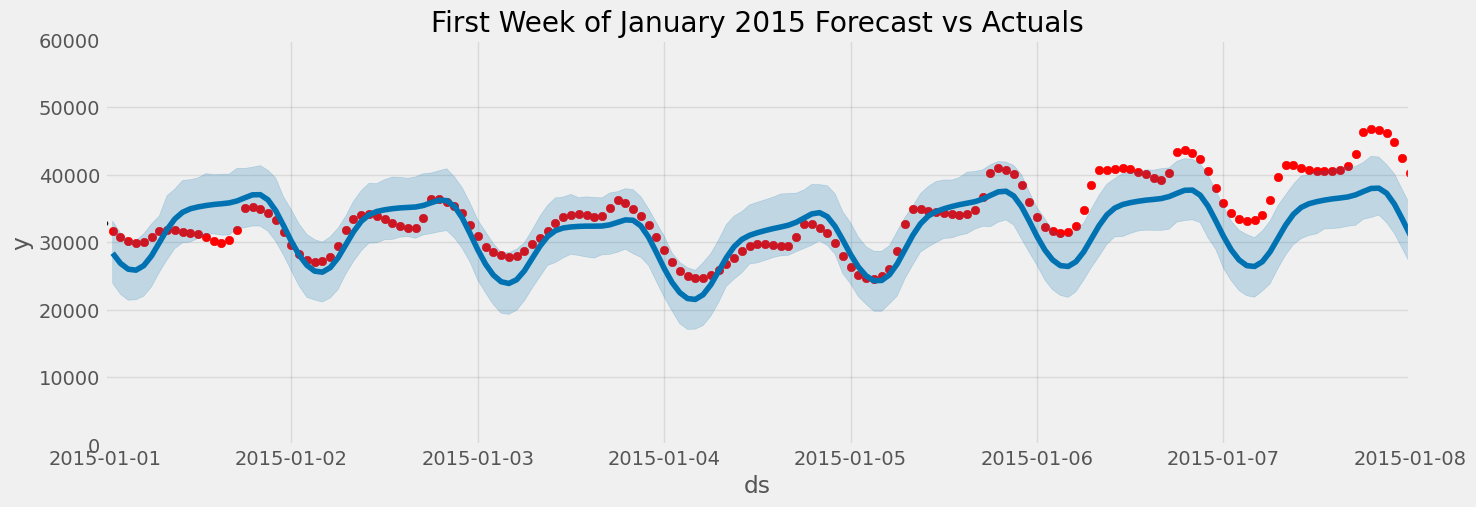

In [16]:
# Plot the forecast with the actuals
lower_date = pd.to_datetime('2015-01-01')
upper_date = pd.to_datetime('2015-01-08')

f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Set x-axis bounds using datetime objects
ax.set_xbound(lower=lower_date, upper=upper_date)
ax.set_ylim(0, 60000)
ax.set_title('First Week of January 2015 Forecast vs Actuals')
plt.show()


# Evaluate the model with Error Metrics

In [17]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))                                                                                                                     

6619.0084438739295

In [18]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])                                                                                                        

5183.308123570645

# Adding Holidays

Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [19]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [ ]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

22:03:48 - cmdstanpy - INFO - Chain [1] start processing


In [ ]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

In [ ]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

In [ ]:
lower_date = pd.to_datetime('2015-07-01')
upper_date = pd.to_datetime('2015-07-07')

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)

# Set x-axis bounds using datetime objects
ax.set_xbound(lower=lower_date, upper=upper_date)
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Predictions vs Actual')
plt.show()

In [ ]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))                                                                                        

In [ ]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])                                                                                               

# The End

# Thank You #